In [17]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
#from mlxtend.plotting import plot_decision_regions

## __1 - Business Problem__  
___Classify the Size_Categorie using SVM___  

## __2 - Data collection and description__ 

In [18]:
df = pd.read_csv("forestfires.csv")

In [19]:
df1 = df.copy()

In [20]:
df1.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [21]:
df1.shape

(517, 31)

In [22]:
df1[df1.columns[0:11]].describe().T

,count,mean,std,min,25%,50%,75%,max
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40
area,517.0,12.847292,63.655818,0.0,0.0,0.52,6.57,1090.84


## From the above we say that Rain has right skew 

In [23]:
df1[df1.columns[0:11]].isnull().sum()

month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

### Finding Correlation

In [24]:
corr = df1[df1.columns[0:11]].corr()

<AxesSubplot:>

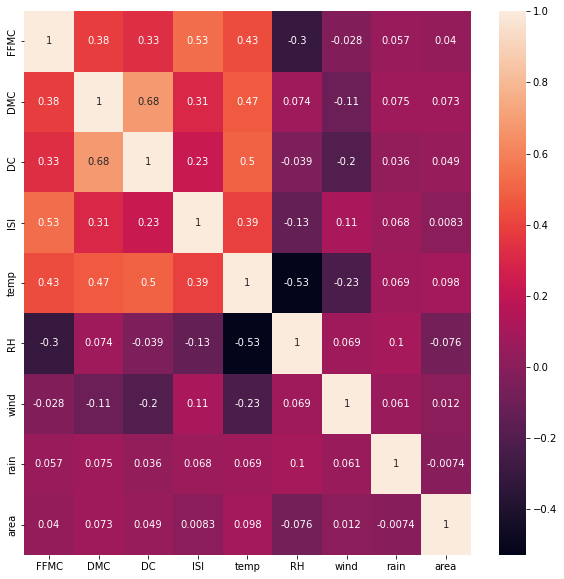

In [25]:
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

### Outlier Check

D:\ProgramFiles\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


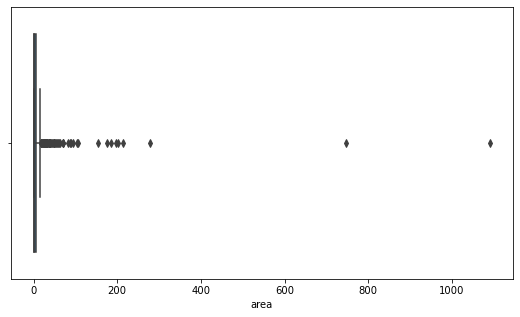

In [26]:
ax = sns.boxplot(df1['area'])

### There are 3 Outlier instances in our data

In [27]:
plt.rcParams["figure.figsize"] = 9,5

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


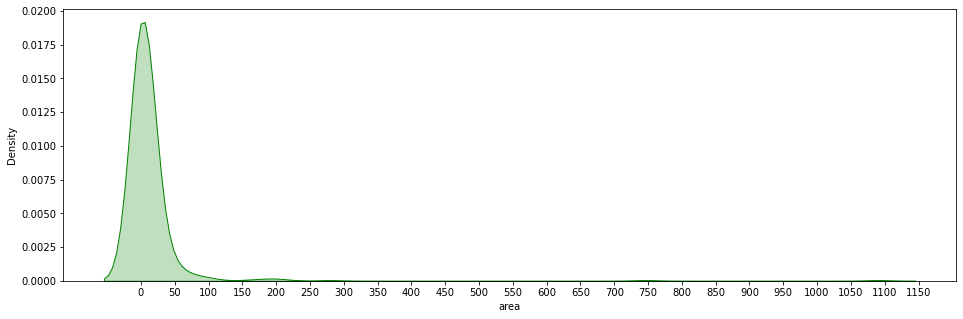

In [28]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(df1['area'].skew()))
print("Kurtosis: {}".format(df1['area'].kurtosis()))
ax = sns.kdeplot(df1['area'],shade=True,color='g')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

### The Data is highly skewed and has large kurtosis value  
### Majority of the forest fires do not cover a large area, most of the damaged area is under 100 hectares of land

In [29]:
dfa = df1[df1.columns[0:10]]
month_colum = dfa.select_dtypes(include='object').columns.tolist()

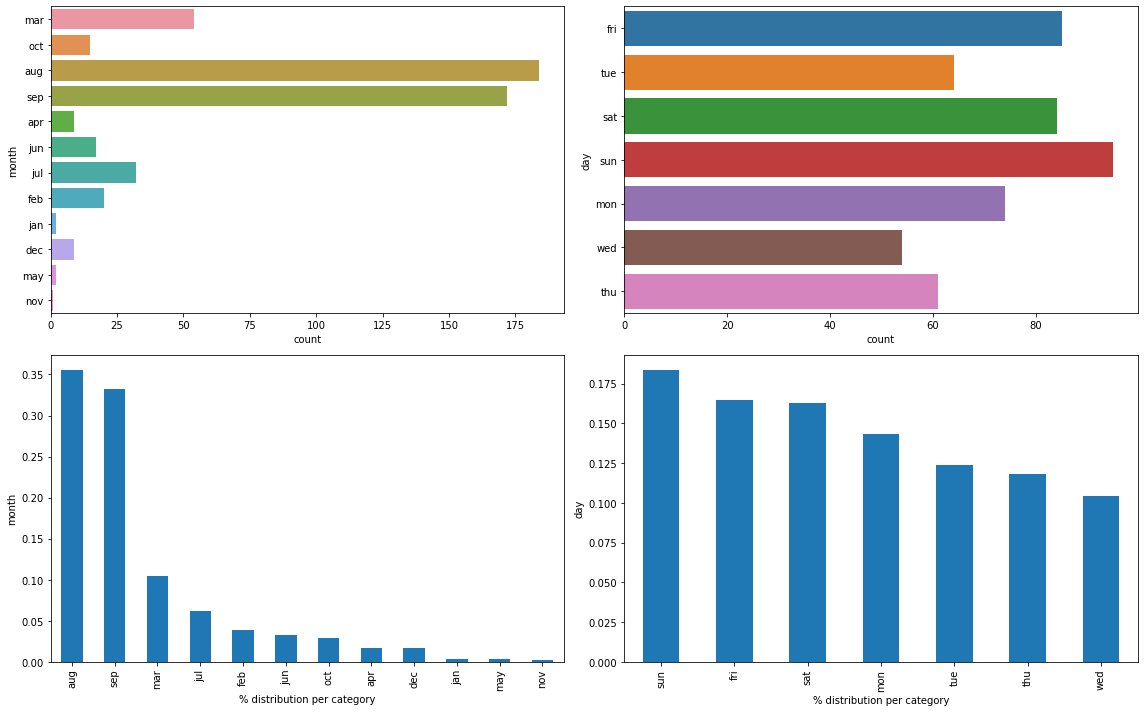

In [30]:
plt.figure(figsize=(16,10))
for i,col in enumerate(month_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=dfa,y=col)
    plt.subplot(2,2,i+2)
    df1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()  

### Majority of the fire accors in the month Aug and Sep  
### For Days Sun and Fri have recoreded the most cases

In [31]:
num_columns = dfa.select_dtypes(exclude='object').columns.tolist()

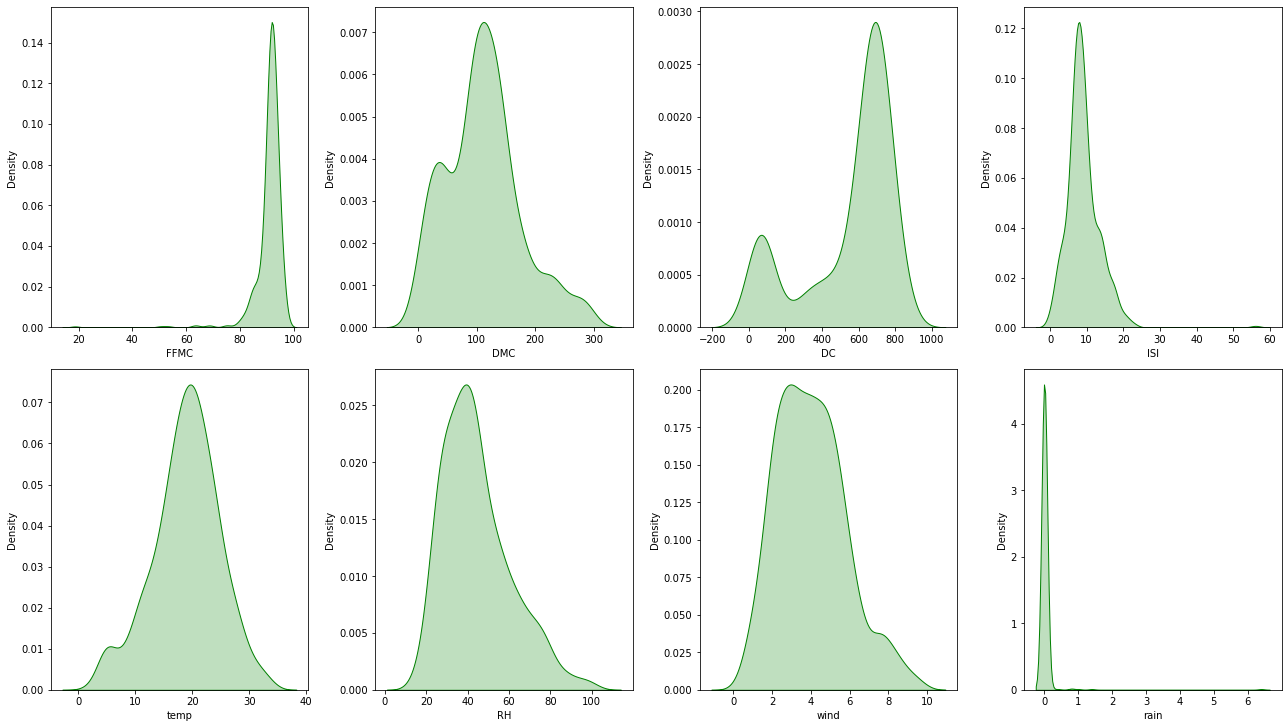

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


In [34]:
plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(df[col],color='g',shade=True)
    #plt.subplot(8,4,i+10)
    #df[col].plot.box()
plt.tight_layout() 
plt.show()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

## __3 - SVM__ 

In [35]:
X = df1.iloc[:,2:30]
y = df1.iloc[:,30]

In [36]:
mapping = {'small': 1, 'large': 2}

In [37]:
y = y.replace(mapping)

In [38]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.20, stratify = y)

### 3.1 Linear

In [39]:
model_linear = SVC(kernel = "linear")
model_linear.fit(x_train,y_train)
pred_test_linear = model_linear.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred_test_linear))

Accuracy: 0.9711538461538461


### 3.2 Poly

In [40]:
model_poly = SVC(kernel = "poly")
model_poly.fit(x_train,y_train)
pred_test_poly = model_poly.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred_test_poly))

Accuracy: 0.7884615384615384


### 3.3 RBF

In [41]:
model_rbf = SVC(kernel = "rbf")
model_rbf.fit(x_train,y_train)
pred_test_rbf = model_rbf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred_test_rbf))

Accuracy: 0.7596153846153846


### 3.4 Sigmoid

In [42]:
model_sigmoid = SVC(kernel = "sigmoid")
model_sigmoid.fit(x_train,y_train)
pred_test_sigmoid = model_sigmoid.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred_test_sigmoid))

Accuracy: 0.6538461538461539


## Linear giives us the best Accuracy